# Performing a parameter sweep

The objective of this task is to optimize the parameters of the BM25 retrieval model (b and k1) in a systematic way. 

The proper solution would be to do an extensive grid search, as b and k1 are not independent of each other. The pseudo code for that would look something like:

```
for b between 0 and 1 in 0.1 steps
    for k between 1 and 2 in 0.1 steps
        perform retrieval using b and k
        evaluate
pick b and k with highest overall performance (MAP score)
```

As this would take a lot of time, what we do instead in this exercise is the following:
  - keep the default k1 value (1.2) and perform a sweep on b
  - use the best performing b value and perform a sweep on k1
  
This may not be a global optimum, but should give better results than the default setting.

**NOTE** The solution is incomplete; those parts of the code that should be developed as part of Assignment 1 are removed.

In [160]:
from elasticsearch import Elasticsearch
import time
import matplotlib.pyplot as plt
import pprint

In [161]:
INDEX_NAME = "aquaint"
DOC_TYPE = "doc"
FIELD = "content"

In [162]:
QUERY_FILE = "data/queries.txt"
OUTPUT_FILE = "data/bm_optimized.txt"
QRELS_FILE = "data/qrels2.csv"

In [163]:
def load_queries(query_file):
    queries = {}
    with open(query_file, "r") as fin:
        for line in fin.readlines():
            qid, query = line.strip().split(" ", 1)
            queries[qid] = query
    return queries

In [164]:
def eval_query(ranking, gt):
    p10, ap, rr, num_rel = 0, 0, 0, 0
        
    
    for i, doc_id in enumerate(ranking):
        if doc_id in gt:  # doc is relevant
            num_rel += 1  
            pi = num_rel / (i + 1)  # P@i
            ap += pi  # AP
            
            if i < 10:  # P@10
                p10 += 1
            if rr == 0:  # Reciprocal rank
                rr = 1 / (i + 1)
    p10 /= 10
    ap /= len(gt)
    
    return {"P10": p10, "AP": ap, "RR": rr}

In [165]:
def eval(gt_file, output_file):
    # load data from ground truth file
    gt = {}  # holds a list of relevant documents for each queryID
    with open(gt_file, "r") as fin:
        header = fin.readline().strip()
        if header != "queryID,docIDs":
            raise Exception("Incorrect file format!")
        for line in fin.readlines():
            qid, docids = line.strip().split(",")
            gt[qid] = docids.split()

    # load data from output file
    output = {}
    with open(output_file, "r") as fin:
        header = fin.readline().strip()
        if header != "QueryId,DocumentId":
            raise Exception("Incorrect file format!")
        for line in fin.readlines():
            qid, docid = line.strip().split(",")
            if qid not in output:
                output[qid] = []
            output[qid].append(docid)

    # evaluate each query that is in the ground truth
    #print("  QID  P@10   (M)AP  (M)RR")
    sum_p10, sum_ap, sum_rr, length = 0, 0, 0, 0
    for qid in sorted(gt.keys()):
        res = eval_query(output.get(qid, []), gt.get(qid, []))
        sum_p10 += res["P10"]
        sum_ap += res["AP"]
        sum_rr += res["RR"]
        length += 1

    # TODO compute averages over the entire query set
    sum_p10 = sum_p10/length
    sum_ap = sum_ap/length
    sum_rr = sum_rr/length
    # print averages
    print(sum_ap)
    #print("%5s %6.3f %6.3f %6.3f " % ("ALL", sum_p10, sum_ap, sum_rr))
    return sum_ap

In [166]:
queries = load_queries(QUERY_FILE)

In [167]:
es = Elasticsearch()

### Perform a sweep on b

In [168]:
map_scores = []
x = []
y = {}
for i in range(11):
    b = round(i / 10, 2) 
    x.append(b)
    print("Running queries for b=%f" % b)
    
    # TODO run retrieval using k1=1.2 and b
    SIM = {"similarity": {"default": { "type": "BM25","b": b,"k1": 1.2}}}
    es.indices.close(index=INDEX_NAME)
    es.indices.put_settings(index=INDEX_NAME, body=SIM)
    es.indices.open(index=INDEX_NAME)
    time.sleep(2)
    # TODO run retrieval using k1=1.2 and b
    #es.search(index=INDEX_NAME, q=query, df="content", _source=False, size=200).get('hits', {})
    f = open(OUTPUT_FILE, 'w')
    f.write('QueryId,DocumentId\n') 
    for q_id, query in queries.items():
        res = es.search(index=INDEX_NAME, doc_type=DOC_TYPE, q=query, df="content", size=100,  filter_path=['hits.hits._id'])
        for i in res['hits']['hits']:
            for j in i:
                f.write(str(q_id)+","+i[j]+'\n')
    f.close() 
    # TODO evaluate the ranking
    
    map_score = eval(QRELS_FILE, OUTPUT_FILE)
    y[b] = map_score
    map_scores.append(map_score)

Running queries for b=0.000000
0.07749778586097134
Running queries for b=0.100000
0.08277168231797909
Running queries for b=0.200000
0.08136968450637774
Running queries for b=0.300000
0.07854461481944872
Running queries for b=0.400000
0.07675254711018994
Running queries for b=0.500000
0.07432063651363362
Running queries for b=0.600000
0.06978918735150118
Running queries for b=0.700000
0.0666243773540211
Running queries for b=0.800000
0.0593819538704358
Running queries for b=0.900000
0.05477416480675029
Running queries for b=1.000000
0.049880068370967146


0.077
0.083
0.081
0.079
0.077
0.074
0.070
0.067
0.059
0.055
0.050


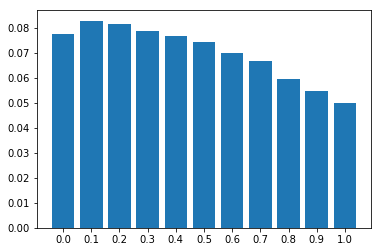

In [169]:
b_map=list(y.values())
z=0
for d in range(0,11,1):
    b_map[z] = "%.3f" % b_map[z]
    print(b_map[z])
    z+=1

plt.bar(range(len(y)), y.values(), align="center")
plt.xticks(range(len(y)), list(y.keys()))
plt.show()

**TODO** Plot MAP scores for the various b values

### Perform a sweep on k1

Use the best performing b value from above and optimize k1

In [170]:
map_scores = []
x = []
h={}
for i in range(11):
    k1 = 1 + round(i / 10, 2) 
    x.append(k1)
    print("Running queries for k1=%f" % k1)
    SIM = {"similarity": {"default": { "type": "BM25","b": 0.1,"k1": k1}}}
    es.indices.close(index=INDEX_NAME)
    es.indices.put_settings(index=INDEX_NAME, body=SIM)
    es.indices.open(index=INDEX_NAME)
    time.sleep(2)
    # TODO run retrieval using k1=1.2 and b
    #es.search(index=INDEX_NAME, q=query, df="content", _source=False, size=200).get('hits', {})
    f = open(OUTPUT_FILE, 'w')
    f.write('QueryId,DocumentId\n') 
    for q_id, query in queries.items():
        res = es.search(index=INDEX_NAME, doc_type=DOC_TYPE, q=query, df="content", size=100,  filter_path=['hits.hits._id'])
        for i in res['hits']['hits']:
            for j in i:
                f.write(str(q_id)+","+i[j]+'\n')
    f.close() 
    # TODO evaluate the ranking
    
    map_score = eval(QRELS_FILE, OUTPUT_FILE)
    h[k1] = map_score
    map_scores.append(map_score)

Running queries for k1=1.000000
0.08271382547317722
Running queries for k1=1.100000
0.08288520015126824
Running queries for k1=1.200000
0.08277168231797909
Running queries for k1=1.300000
0.0829651584938024
Running queries for k1=1.400000
0.0829403030889661
Running queries for k1=1.500000
0.08269708018489398
Running queries for k1=1.600000
0.08224108437988406
Running queries for k1=1.700000
0.08186170576579523
Running queries for k1=1.800000
0.08170371370221988
Running queries for k1=1.900000
0.0815786692173334
Running queries for k1=2.000000
0.08112993377605558


0.083
0.083
0.083
0.083
0.083
0.083
0.082
0.082
0.082
0.082
0.081


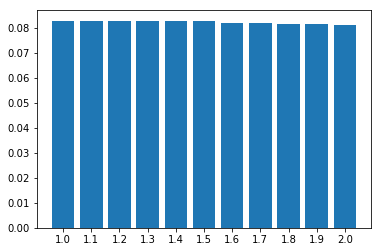

In [171]:
k1_map=list(h.values())
z=0
for d in range(0,11,1):
    k1_map[z] = "%.3f" % k1_map[z]
    print(k1_map[z])
    z+=1
#print(y)

#plt.hist(y,bins =7)

#range=([-1,-0.5],[-0.5,-0.25],[-0.25,-0.05],[-0.5,0.5],[0.5,0.25],[0.25,0.5],[0.5,1]),,)
#plt.show()
#plt.figure(figsize=(20,8))
#plt.bar(range(len(dictionary)), sorted(dictionary.values(),reverse= True), align='center')
#plt.xticks(range(len(dictionary)), sorted(dictionary, key=dictionary.get,reverse=True))
#plt.ylim(-0.75,0.75)

#plt.show()
#plt.bar(range(len(map_scores)),map_scores )
#plt.xticks(x)
#plt.yticks(range(len(map_scores)), b_map )

plt.bar(range(len(h)), h.values(), align="center")
plt.xticks(range(len(h)), list(h.keys()))
plt.show()

**TODO** Plot MAP scores for the various k1 values